# `Baseline` решения

## импорт `YOLO`

In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [97]:
import matplotlib.pyplot as plt
import cv2

In [98]:
# !pip3 install -U ultralytics --user

In [99]:
import ultralytics

In [100]:
from ultralytics import settings
settings.update({"wandb": False, "tensorboard": False, "clearml":False, "mlflow":False, "neptune":False, 'comet': False, 'dvc': False, 'hub': False })

In [101]:
print(settings)

{'settings_version': '0.0.4', 'datasets_dir': 'D:\\Yandex Disk\\Компьютерное зрение\\практики очные\\Короткий CV COurse\\datasets', 'weights_dir': 'weights', 'runs_dir': 'runs', 'uuid': 'e6e830fcb721a7c37fbbf7d832aecf0518808b2940252e20b03bd1656987def9', 'sync': True, 'api_key': '', 'openai_api_key': '', 'clearml': False, 'comet': False, 'dvc': False, 'hub': False, 'mlflow': False, 'neptune': False, 'raytune': True, 'tensorboard': False, 'wandb': False}


Также `ultralytics` предоставляют собственный интерфейс проверки вычислителей.

In [102]:
ultralytics.checks()

Ultralytics YOLOv8.2.77  Python-3.12.3 torch-2.4.0 CPU (Intel Core(TM) i5-7400 3.00GHz)
Setup complete  (4 CPUs, 15.9 GB RAM, 562.7/931.5 GB disk)


In [103]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

In [104]:
model.info()

YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

## Импорты

In [11]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [12]:
from urllib.request import urlretrieve
from torchvision.datasets.utils import download_and_extract_archive

## Пути к набору данных

### путь к набору данных

In [13]:
root_path = Path(os.getcwd()) 
print(list(root_path.iterdir()))

[WindowsPath('D:/Yandex Disk/ObjDetV2/.ipynb_checkpoints'), WindowsPath('D:/Yandex Disk/ObjDetV2/archive (22).zip'), WindowsPath('D:/Yandex Disk/ObjDetV2/LU3M6TGT_yolo_format'), WindowsPath('D:/Yandex Disk/ObjDetV2/WS8_YOLOv8 API.ipynb'), WindowsPath('D:/Yandex Disk/ObjDetV2/yolov8n.pt')]


In [31]:
dataset_path = root_path / 'craters' #'LU3M6TGT_yolo_format'
print(list(dataset_path.iterdir()))

[WindowsPath('D:/Yandex Disk/ObjDetV2/craters/test'), WindowsPath('D:/Yandex Disk/ObjDetV2/craters/train'), WindowsPath('D:/Yandex Disk/ObjDetV2/craters/valid')]


### путь к тренировочной и к валидационной части

In [33]:
ext = 'jpg' #'png'

In [34]:
images_path = dataset_path / 'train' / 'images'
labels_path = dataset_path / 'train' / 'labels'

labels_path = list(labels_path.glob('**/*.txt'))
images_path = list(images_path.glob(f'**/*.{ext}'))


In [35]:
val_image_path  = dataset_path / 'valid' / 'images'
val_labels_path = dataset_path / 'valid' / 'labels'

val_labels_path = list(val_labels_path.glob('**/*.txt'))
val_image_path  = list(val_image_path.glob(f'**/*.{ext}'))



In [169]:
test_images_path = dataset_path / 'test' / 'images'

test_images_path = list(test_images_path.glob(f'**/*.{ext}'))

In [170]:
test_images_path[1]

WindowsPath('D:/Yandex Disk/ObjDetV2/craters/test/images/015_png.rf.7d5b2091b6339c9480a171a59c52c3b9.jpg')

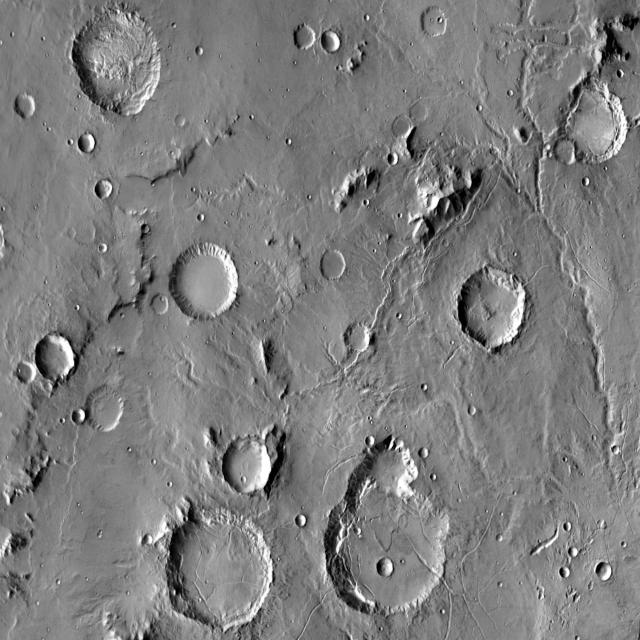

In [171]:
Image.open(images_path[1])

### описание набора данных

In [349]:
data_yaml = dataset_path  / 'data.yaml'
data_yaml

WindowsPath('D:/Yandex Disk/ObjDetV2/craters/data.yaml')

In [353]:
import yaml

data = {
    f'train': str(dataset_path / 'train' / 'images'),
    f'val': str(dataset_path / 'valid' / 'images'),
    'nc': 1,
    'names': ['0']
}

with open(data_yaml, 'w') as file:
    yaml.safe_dump(data, file)

print("New YAML file created successfully.")

with open(data_yaml, 'r') as file:
    data=yaml.safe_load( file)
print(data)

New YAML file created successfully.
{'names': ['0'], 'nc': 1, 'train': 'D:\\Yandex Disk\\ObjDetV2\\craters\\train\\images', 'val': 'D:\\Yandex Disk\\ObjDetV2\\craters\\valid\\images'}


## Построение примеров данных

In [40]:
def yolo2coco(xc, yc, w, h, image_width, image_height):
    xc, w = xc*image_width,  w*image_width
    yc, h = yc*image_height, h*image_height
    xmin = xc - w//2
    ymin = yc - h//2
    return xmin,ymin,w, h

def plot_bbox(image_pth, ann_pth = None, predicted_boxes = None, pred_classes = None):
    image =  np.asarray(Image.open(image_pth))
    height, width = image.shape[:2]

    if ann_pth == None:
        ann_name = image_pth.parts[-1][:-4]+'.txt'
        ann_pth = Path(*image_pth.parts[:-2]) / 'labels'/ann_name
    data = pd.read_csv(ann_pth, sep=" ", header=None).values     
    
    bbox   = np.asarray(data)[:,1:5]
    
    fig, axs = plt.subplots(1, 2, figsize = (8,4))
    image_ = np.copy(image).astype(float)/image.max()
    
    # Ground Truth    
    axs[0].imshow(np.clip(image_,0,1), 'gray')
    axs[0].axis('off'); axs[0].set_title('Original Image')
    #----------------------------
    
    # Object Detection BBoxes
    axs[1].imshow(np.clip(image_,0,1), 'gray')
    
    for box in bbox:
        xmin,ymin,w,h = yolo2coco(*box, width,height)
        bb = patches.Rectangle(xy     = (xmin,ymin), 
                               width  = w,height = h, 
                               linewidth=2, edgecolor="blue", facecolor="none")
        axs[1].add_patch(bb)  

    if predicted_boxes != None:
        if pred_classes == None:
            pred_classes = ['0']*len(predicted_boxes)
        for cls,box in zip(np.array(pred_classes),np.array(predicted_boxes)):
            xmin,ymin,w,h = yolo2coco(*box, width,height)
            bb = patches.Rectangle(xy     = (xmin,ymin), 
                                   width  = w,height = h, 
                                   linewidth=2, edgecolor="red", facecolor="none")
            axs[1].add_patch(bb)


            axs[1].text(xmin,ymin,str(cls),fontsize=10, color="green", weight="bold")
    
    axs[1].axis('off'); axs[1].set_title('Object Detection')
    plt.tight_layout()
    plt.show()

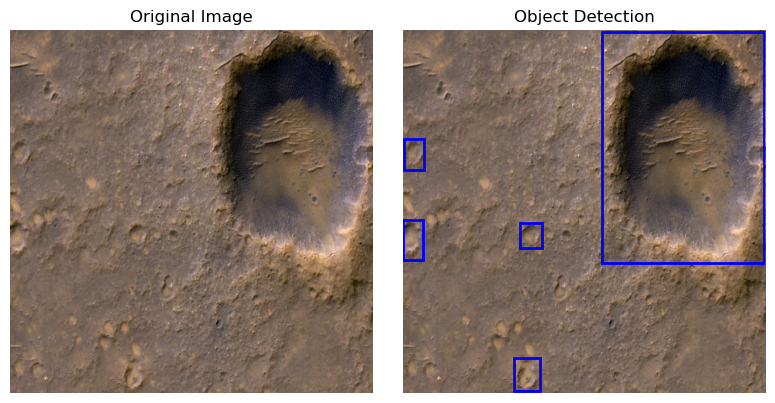

In [41]:
plot_bbox(images_path[47] )

## Проверка модели и построение результата

In [42]:
model = YOLO("yolov8n.pt")

results = model(images_path[47])


image 1/1 D:\Yandex Disk\ObjDetV2\craters\train\images\mars_crater--35-_jpg.rf.826bc4b2a3a69c48144834f40d92439f.jpg: 640x640 (no detections), 188.0ms
Speed: 6.0ms preprocess, 188.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


In [43]:
def plot_result(result):
    image_pth = Path(result.path)
    image =  np.asarray(Image.open(image_pth))
    height, width = image.shape[:2]

    ann_name = image_pth.parts[-1][:-4]+'.txt'
    ann_pth = Path(*image_pth.parts[:-2]) / 'labels'/ann_name
    data = pd.read_csv(ann_pth, sep=" ", header=None).values     
    
    bbox   = np.asarray(data)[:,1:5]
    
    fig, axs = plt.subplots(1, 2, figsize = (8,4))
    image_ = np.copy(image).astype(float)/image.max()
    
    # Ground Truth    
    axs[0].imshow(np.clip(image_,0,1), 'gray')
    axs[0].axis('off'); axs[0].set_title('Original Image')
    #----------------------------
    
    # Object Detection BBoxes
    axs[1].imshow(np.clip(image_,0,1), 'gray')
    
    for box in bbox:
        xmin,ymin,w,h = yolo2coco(*box, width,height)
        bb = patches.Rectangle(xy     = (xmin,ymin), 
                               width  = w,height = h, 
                               linewidth=2, edgecolor="blue", facecolor="none")
        axs[1].add_patch(bb)  

    predicted_boxes = result.boxes.xywhn
    pred_classes = result.boxes.cls.long()
    if pred_classes == []:
        pred_classes = len(predicted_boxes)*['0']
    
    if predicted_boxes != None:
        if pred_classes == None:
            pred_classes = ['0']*len(predicted_boxes)
        
        for cls,box in zip(np.array(pred_classes),np.array(predicted_boxes)):
            xmin,ymin,w,h = yolo2coco(*box, width,height)
            bb = patches.Rectangle(xy     = (xmin,ymin), 
                                   width  = w,height = h, 
                                   linewidth=2, edgecolor="red", facecolor="none")
            axs[1].add_patch(bb)


            axs[1].text(xmin,ymin,str(cls),fontsize=10, color="green", weight="bold")
    
    axs[1].axis('off'); axs[1].set_title('Object Detection')
    plt.tight_layout()
    plt.show()

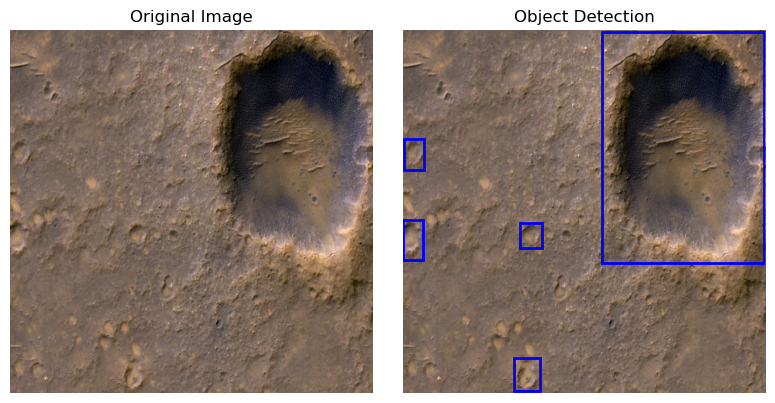

In [44]:
plot_result(results[0] )

## Тренировка модели

In [354]:
model = YOLO("yolov8n.pt")
results = model.train(data=data_yaml,imgsz=640, epochs = 12)

New https://pypi.org/project/ultralytics/8.2.82 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.77  Python-3.12.3 torch-2.4.0 CPU (Intel Core(TM) i5-7400 3.00GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:\Yandex Disk\ObjDetV2\craters\data.yaml, epochs=12, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

train: Scanning D:\Yandex Disk\ObjDetV2\craters\train\labels.cache... 98 images, 9 backgrounds, 0 corrupt: 100%|███████

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning D:\Yandex Disk\ObjDetV2\craters\test\labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████


Plotting labels to runs\detect\train9\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train9
Starting training for 12 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/12         0G      1.752      3.367      1.413         30        640: 100%|██████████| 7/7 [00:57<00:00,  8.26
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<0

                   all         19        151     0.0144      0.543     0.0679     0.0358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/12         0G      1.677      2.457      1.299         54        640: 100%|██████████| 7/7 [00:51<00:00,  7.42
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         19        151      0.765      0.119      0.205      0.104


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/12         0G      1.614      2.167      1.249         50        640: 100%|██████████| 7/7 [00:38<00:00,  5.53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all         19        151     0.0327      0.682      0.175      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/12         0G      1.625      1.936      1.246         15        640: 100%|██████████| 7/7 [00:37<00:00,  5.34
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all         19        151     0.0207      0.781      0.219      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/12         0G      1.291      5.522      1.055          0        640: 100%|██████████| 7/7 [00:37<00:00,  5.33
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all         19        151     0.0958      0.358      0.197      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/12         0G       1.55      1.654      1.238         28        640: 100%|██████████| 7/7 [00:39<00:00,  5.59
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         19        151     0.0726      0.377      0.226      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/12         0G      1.441      1.897      1.289          2        640: 100%|██████████| 7/7 [00:39<00:00,  5.68
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all         19        151      0.951      0.129      0.333      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/12         0G      1.477      1.636      1.244          5        640: 100%|██████████| 7/7 [00:42<00:00,  6.05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         19        151      0.863      0.126      0.312      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/12         0G      1.407       1.56      1.151         32        640: 100%|██████████| 7/7 [00:41<00:00,  5.89
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all         19        151      0.859      0.146      0.401      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/12         0G        1.5      1.522      1.157         10        640: 100%|██████████| 7/7 [00:39<00:00,  5.60
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         19        151       0.88      0.232        0.5      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/12         0G      1.499      1.576      1.181         20        640: 100%|██████████| 7/7 [00:39<00:00,  5.58
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0

                   all         19        151      0.872      0.272      0.513      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/12         0G      1.429       1.57      1.173         19        640: 100%|██████████| 7/7 [00:41<00:00,  5.95
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         19        151      0.783      0.286      0.512      0.282



12 epochs completed in 0.160 hours.
Optimizer stripped from runs\detect\train9\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train9\weights\best.pt, 6.2MB

Validating runs\detect\train9\weights\best.pt...
Ultralytics YOLOv8.2.77  Python-3.12.3 torch-2.4.0 CPU (Intel Core(TM) i5-7400 3.00GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<0


                   all         19        151      0.874      0.272      0.513      0.284
Speed: 3.9ms preprocess, 118.5ms inference, 0.0ms loss, 13.2ms postprocess per image
Results saved to runs\detect\train9


## Проверка результата на валидации

### все результаты

In [356]:
results = model.val(data=data_yaml,imgsz=640)

Ultralytics YOLOv8.2.77  Python-3.12.3 torch-2.4.0 CPU (Intel Core(TM) i5-7400 3.00GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\Yandex Disk\ObjDetV2\craters\test\labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0


                   all         19        151      0.874      0.272      0.513      0.284
Speed: 2.8ms preprocess, 96.8ms inference, 0.0ms loss, 12.0ms postprocess per image
Results saved to runs\detect\train92


### Целевой результат

In [357]:
print(f'map 50:95 = {results.box.map:.3f}')  # map50-95

map 50:95 = 0.284


### Проверим что модель что то находит на тестовых данных

In [358]:
results = model(test_images_path[:], )


0: 640x640 2 0s, 91.2ms
1: 640x640 1 0, 91.2ms
2: 640x640 (no detections), 91.2ms
3: 640x640 (no detections), 91.2ms
4: 640x640 1 0, 91.2ms
5: 640x640 (no detections), 91.2ms
6: 640x640 (no detections), 91.2ms
7: 640x640 (no detections), 91.2ms
8: 640x640 (no detections), 91.2ms
9: 640x640 1 0, 91.2ms
10: 640x640 1 0, 91.2ms
11: 640x640 (no detections), 91.2ms
12: 640x640 (no detections), 91.2ms
13: 640x640 (no detections), 91.2ms
14: 640x640 (no detections), 91.2ms
15: 640x640 1 0, 91.2ms
16: 640x640 (no detections), 91.2ms
17: 640x640 (no detections), 91.2ms
18: 640x640 (no detections), 91.2ms
Speed: 3.8ms preprocess, 91.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


Результаты модели можно проверить "на глаз" при желании.

## Как найти обученную модель для подачи на проверку.

* Модель можно найти в описании тренировки - параметр `save_dir` например в виде `=runs\detect\train9`
* Также можно поменять директорию для сохранения модели как `settings.update({'runs_dir': '/path/to/runs'})`
* В директории как правило будут два файла `last.pt` и `best.pt`. Нужен  `best.pt`.
* Файл `best.pt` нужно сохранить под своим именем и сдать.
* Проверить модель можно так, как это показано ниже.
* Отметим, что загруженную модель также можно дообучить при желании.

Также отметим что путь к обученной модели можно получить следующим образом:

In [375]:
save_dir = model.trainer.save_dir 
best_trained_weights = save_dir / 'weights' / 'best.pt'
best_trained_weights

WindowsPath('runs/detect/train9/weights/best.pt')

In [377]:
model = YOLO(best_trained_weights)  # load a partially trained model
# results = model.train(data=data_yaml,imgsz=640, epochs = 7)
results = model.val(data=data_yaml,imgsz=640)

Ultralytics YOLOv8.2.77  Python-3.12.3 torch-2.4.0 CPU (Intel Core(TM) i5-7400 3.00GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\Yandex Disk\ObjDetV2\craters\test\labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<0


                   all         19        151      0.874      0.272      0.513      0.284
Speed: 3.6ms preprocess, 113.3ms inference, 0.0ms loss, 12.9ms postprocess per image
Results saved to runs\detect\val10


# Задание на итоговый проект

__Цель__ - обучить нейронную сеть типа `YOLO` для решения проблемы поиска и определения краторов на изобажениях лунохода.

Действия:
1. Прочитать пример работы с набором данных.
2. Обучить модель детекции краторов, используюя целевую метрику `map50:95`
3. Выгрузить обученную модель (файл `best.pt`).
4. Переименовать модель в соответствии с фио на Английском языке и сдать ее.
5. Модель должна дать на тестовой части набора данных точность не ниже 40%. В противном случае баллы будут снижены в двое.
6. На решение задачи дается 2 попытки